# Homework set 2

Please **submit this Jupyter notebook through Canvas** no later than **Thursday November 13**. **Submit the notebook file with your answers (as .ipynb file) and a pdf printout. The pdf version can be used by the teachers to provide feedback. On canvas there are hints about creating a nice pdf version.**

Before you hand in, please make sure the notebook runs, by running "Restart kernel and run all cells..." from the Kernel menu.

Homework is in **groups of two**, and you are expected to hand in original work. Work that is copied from another group will not be accepted.

# Exercise 0
Write down the names + student ID of the people in your group.

Emma van der Spek -- 13274864

Maarten Stork -- 15761770

Run the following cell to import NumPy and Pyplot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1

In this exercise we consider interpolating a function $f$ on an interval $[a,b]$ with 5 regularly spaced points, including the end points.

## (a)

Let $a = 0.2$, $b=0.6$ (so spacing $0.1$ between the points), and let $f(x) = \cos(x)$.

Compute an interpolating polynomial $p(x)$ for $f$ by solving a linear system of equations using the monomial basis. Plot $p(x)$ and $f(x)$ (I suggest using the same plot and so that they are both visible). Also plot the interpolation error. Annotate your plots.

Then do the same with $a = 1000 \cdot \pi +0.2$ and $b = 1000\cdot \pi + 0.6$.

Describe briefly any notable differences in the resulting plots.


In [25]:
def construct_Vandermonde(t: list):
    """Returns the Vandermonde matrix for the monomial basis of polynomial interpolation."""
    m = len(t) # sets shape of matrix
    M = np.array([[t[j]**i for i in range(m)] for j in range(m)])
    return M

def f(t: list):
    """Function to approximate through interpolation."""
    return np.cos(np.array(t))

def monomial_interpolation(x: list, t: list):
    """Constructs an interpolant p(t) through monomial decomposition. The arguments are 
        - x: the array of monomial coefficients;
        - t: an array of values for the argument of the function to compute the interpolant for.
    Returns the array of values of the interpolant evaluated at t."""
    p = [np.sum([x[i]*t[j]**i for i in range(len(x))]) for j in range(len(t))]
    return p

In [3]:
starts = [0.2, 1000*np.pi + 0.2] 
ends = [0.6, 1000*np.pi + 0.6]
xs = []

for i in range(len(starts)):
    t = np.linspace(starts[i], ends[i], 5)
    b = f(t)
    A = construct_Vandermonde(t)
    x = np.linalg.solve(A, b)
    xs.append(x)

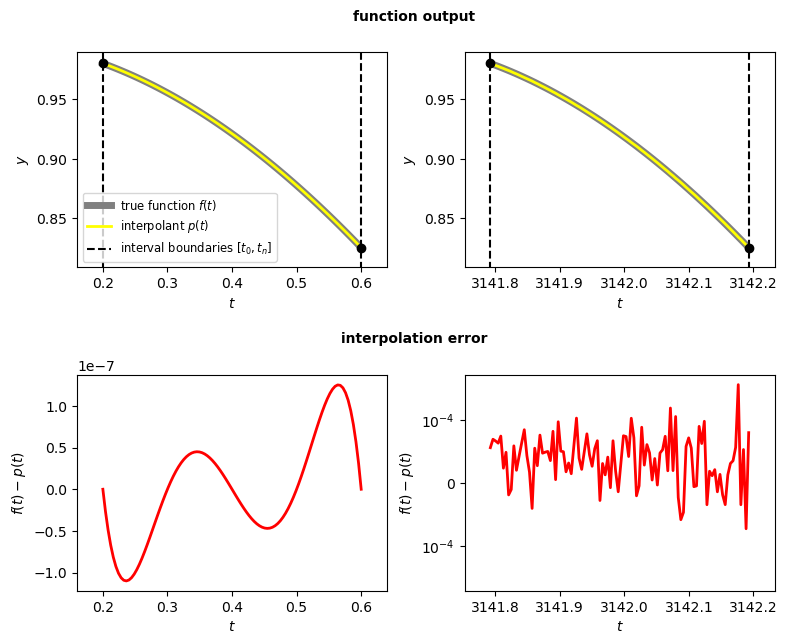

In [4]:
fig, axs = plt.subplots(2, len(xs), figsize=(9,7))
for i in range(len(axs)):
    t_plot = np.linspace(starts[i], ends[i], 100)
    true_f = f(t_plot)
    interpolant = monomial_interpolation(xs[i], t_plot)
    ax = axs[0, i]
    ax.plot(t_plot, true_f, "-", linewidth=5, color="grey", label="true function $f(t)$" if i==0 else "")
    ax.plot(t_plot, interpolant, linestyle="-", linewidth=2, color="yellow", label="interpolant $p(t)$" if i==0 else "")
    ax.plot([t_plot[0], t_plot[-1]], [true_f[0], true_f[-1]], "o", color="black", markersize=6)
    ax.vlines([t_plot[0], t_plot[-1]], ymin=0, ymax=1, linestyle="--", color="black", label="interval boundaries [$t_0, t_n$]" if i==0 else "")
    ax.set_xlim(np.min(t_plot)-0.1*(np.max(t_plot)-np.min(t_plot)), np.max(t_plot)+0.1*(np.max(t_plot)-np.min(t_plot)))
    ax.set_ylim(np.min(true_f)*0.98, np.max(true_f)*1.01)
    ax.set_xlabel("$t$")
    ax.set_ylabel("$y$")

    axs[1,i].plot(t_plot, true_f-interpolant, "-", linewidth=2, color="red")
    axs[1,i].set_xlim(np.min(t_plot)-0.1*(np.max(t_plot)-np.min(t_plot)), np.max(t_plot)+0.1*(np.max(t_plot)-np.min(t_plot)))
    if i == 1:
        axs[1,i].set_ylim(-1.7e-4, 1.7e-4)
        axs[1,i].set_yticks([-1e-4, 0, 1e-4], [r"$10^{-4}$", "0", r"$10^{-4}$"])
    axs[1,i].set_xlabel("$t$")
    axs[1,i].set_ylabel("$f(t)-p(t)$")

fig.text(x=0.5, y=0.94, s="function output", ha="center", va="top", fontweight="bold")
fig.text(x=0.5, y=0.48, s="interpolation error", ha="center", va="top", fontweight="bold")
axs[0,0].legend(fontsize="small")
plt.subplots_adjust(hspace=0.5, wspace=0.25)

At first sight, both interpolations (yellow lines) appear to be a perfect fit for the true function (grey). However, looking at the interpolation error $f(t)-p(t)$ (red lines), we see that the second choice of interval has a much bigger error, orders of magnitude larger than the first interval. This is because in the second interval, the absolute range $t_f-t_1$ is much smaller when compared to the magnitude of $t$. As a result, the Vandermonde matrix is less well-conditioned.

## (b)

Solve the problem with $a = 1000 \cdot \pi + 0.2$ and $b = 1000 \cdot \pi + 0.6$ again, but now using Newton polynomial basis function.

Compare with the second example of part (a).

In [5]:
def divided_differences(func, tvals):
    """
    Computes the divided difference coefficient π_n = f[t_1, ..., t_n] with the arguments
        - func: f, the function that returns the height of the the graph at the argument t;
        - tvals: the array of length n of values of t between which the function will be interpolated.
    The function is designed to be recursive, such that any length of tvals larger than 1 will be expressed
    in terms of the separate function values f[t_i].
    Returns coefficient π_n for the nth Newton polynomial basis.
    """
    if len(tvals) > 2:
        part1 = divided_differences(func, tvals[1:])
        part2 = divided_differences(func, tvals[:-1])
        div_diff = 1/(tvals[-1]-tvals[0]) * (part1 - part2)
    else:
        div_diff = (func(tvals[1]) - func(tvals[0])) / (tvals[1] - tvals[0])
    return div_diff

def Newton_polynomial(func, tvals, t):
    """
    Computes an interpolant for a function evaluated at a discrete set of argument values based on the
    Newton polynomial basis. The arguments are
        - func: the function to approximate an interpolant for;
        - tvals: an array of values of the argument of func at which it is evaluated;
        - t: the array of values for which the interpolant will be returned.
    Returns the array of values of the interpolant evaluated at t.
    """
    P = np.array([func(tvals[0])]*len(t))
    product = (t - tvals[0]) # π_1
    for i in range(1, len(tvals)):
        coeff = divided_differences(func, tvals[:i+1])
        P += coeff*product
        product *= (t - tvals[i]) # π_i+1
    return P

In [6]:
tvals = np.linspace(starts[1], ends[1], 5)
t_plot = np.linspace(starts[1], ends[1], 100)
Newton_sol = Newton_polynomial(f, tvals, t_plot)
monomial_sol = monomial_interpolation(xs[1], t_plot)
true_f = f(t_plot)
sols = [true_f, monomial_sol, Newton_sol]
errors = [sols[0]-sols[i] for i in [1,2]]

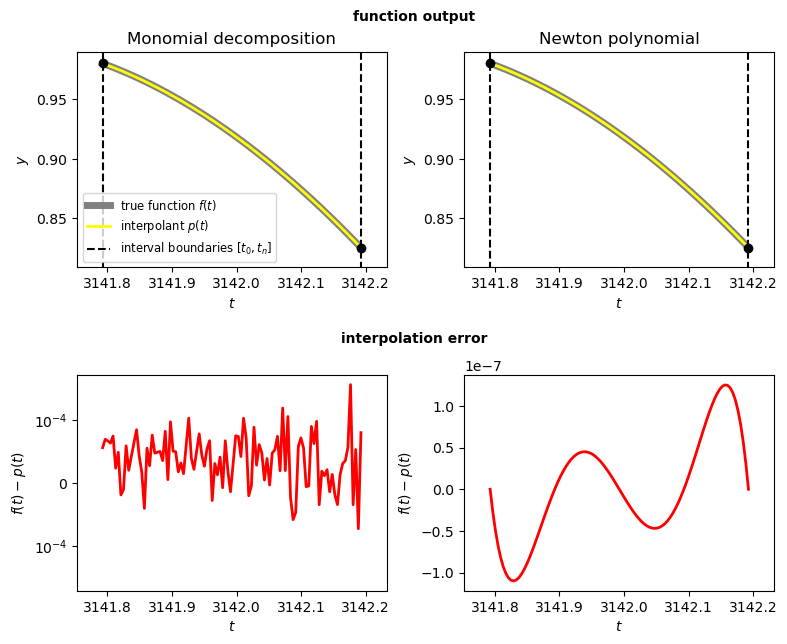

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(9,7))
for i in range(len(axs)):
    ax = axs[0, i]
    ax.plot(t_plot, sols[0], "-", linewidth=5, color="grey", label="true function $f(t)$" if i==0 else "")
    ax.plot(t_plot, sols[i+1], linestyle="-", linewidth=2, color="yellow", label="interpolant $p(t)$" if i==0 else "")
    ax.plot([t_plot[0], t_plot[-1]], [true_f[0], true_f[-1]], "o", color="black", markersize=6)
    ax.vlines([t_plot[0], t_plot[-1]], ymin=0, ymax=1, linestyle="--", color="black", label="interval boundaries [$t_0, t_n$]" if i==0 else "")
    ax.set_xlim(np.min(t_plot)-0.1*(np.max(t_plot)-np.min(t_plot)), np.max(t_plot)+0.1*(np.max(t_plot)-np.min(t_plot)))
    ax.set_ylim(np.min(true_f)*0.98, np.max(true_f)*1.01)
    ax.set_xlabel("$t$")
    ax.set_ylabel("$y$")
    ax.set_title(["Monomial decomposition", "Newton polynomial"][i])

    axs[1,i].plot(t_plot, errors[i], "-", linewidth=2, color="red")
    axs[1,i].set_xlim(np.min(t_plot)-0.1*(np.max(t_plot)-np.min(t_plot)), np.max(t_plot)+0.1*(np.max(t_plot)-np.min(t_plot)))
    if i==0:
        axs[1,i].set_ylim(-1.7e-4, 1.7e-4)
        axs[1,i].set_yticks([-1e-4, 0, 1e-4], [r"$10^{-4}$", "0", r"$10^{-4}$"])
    axs[1,i].set_xlabel("$t$")
    axs[1,i].set_ylabel("$f(t)-p(t)$")

fig.text(x=0.5, y=0.94, s="function output", ha="center", va="top", fontweight="bold")
fig.text(x=0.5, y=0.48, s="interpolation error", ha="center", va="top", fontweight="bold")
axs[0,0].legend(fontsize="small")
plt.subplots_adjust(hspace=0.5, wspace=0.25)

The left column shows the same data as the right column in (a), the right column shows the new interpolant using Newton polynomials. As can be seen, the use of the Newton polynomial basis greatly improves the accuracy of the interpolant; the error is several orders of magnitude smaller than that of the monomial basis. In fact the error is equivalent to that of the monomial basis over the interval [0.2,0.6], indicating that the Newton interpolant is much less sensitive to the shift in $t$.

## (c)

Explain what you see in the error graphs. What kind of errors are dominant in each of the error graphs? Explain the size of the dominant errors in each graph. N.B. a quantitative explanation is requested. Depending on the type of error you may want to have a look at the numbers in the computation of $p$ for finding your explanation.


The upper bound for the error that originates from interpolating a continuous function is defined as 
$$\max_{t\in[t_1, t_n]}|f(t)-p_{n-1}(t)|\leq\frac{Mh^n}{4n},$$
where
* $f(t)$ is the true function
* $p_{n-1}(t)$ is the interpolant, which is a polynomial of order $n-1$
* $M$ is the upper bound for the highest derivative of $f$, i.e. $|f^{(n)}(t)|\leq M$ for all $t\in[t_1,t_n]$
* $h$ is the maximum distance between interpolation points $t_{i+1}-t_i$
* $n$ is the amount of interpolation points.

In our case, $n=5$ and $h=0.1$. Furthermore, the 4th derivative of $\cos(t)$ is again $\cos(t)$, and so $f^{(5)}(t)=\frac{d}{dt}(\cos(t))=-\sin(t)$. $M$ corresponds to the maximum of (the absolute value of) this function in the interval $[t_1,t_n]$, which is $|-\sin(0.6)|=|-\sin(1000\pi+0.6)|\approx 0.56$. Plugging this into the expression above, we get an upperbound for the interpolation error of $\max_{t\in[t_1, t_n]}|f(t)-p_{n-1}(t)|\approx 2.8\cdot 10^{-7}$ (see calculation below).

In [23]:
n = 5
h = 0.1
M = np.abs(-np.sin(0.6))
upperbound_error = M*h**n / (4*n)
print("Upperbound on the error of interpolating a continuous function: ", upperbound_error)

Upperbound on the error of interpolating a continuous function:  2.8232123669751775e-07


The plot below shows an overview of the absolute values of the errors in the three cases tested.

In [9]:
tvals = [np.linspace(starts[0],ends[0],5)] + [np.linspace(starts[1]+0.2,ends[1]+0.6,5)] * 2
t_plots = [np.linspace(starts[0],ends[0],100)] + [np.linspace(starts[1]+0.2,ends[1]+0.6,100)] * 2
sols = [true_f, np.array(monomial_interpolation(xs[0], t_plots[0])), monomial_sol, Newton_sol]
errors = [sols[0]-sols[i] for i in range(1,len(sols))]

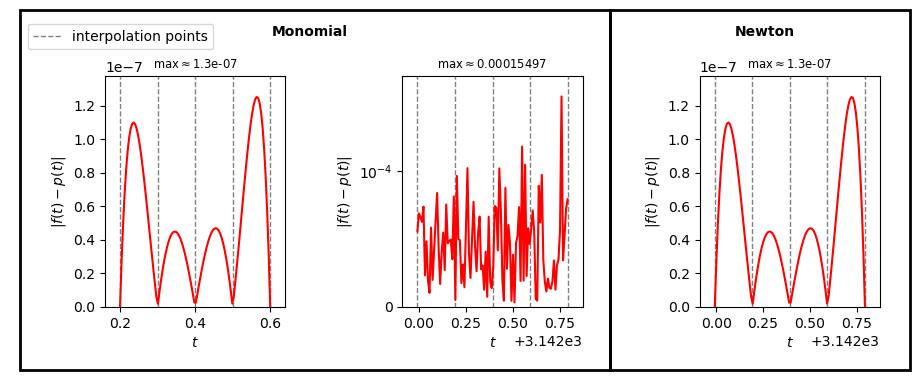

In [10]:
fig, axs = plt.subplots(1, len(sols)-1, figsize=(10,3))
for i in range(len(axs)):
    ax = axs[i]
    t_plot = t_plots[i]
    ax.vlines(tvals[i], np.min(errors[i])*10, np.max(errors[i])*10, linestyle="--", linewidth=1, color="grey", label="interpolation points" if i==0 else "")
    ax.plot(t_plots[i], np.abs(errors[i]), "-", linewidth=1.5, color="red")
    ax.set_xlim(np.min(t_plot)-0.1*(np.max(t_plot)-np.min(t_plot)), np.max(t_plot)+0.1*(np.max(t_plot)-np.min(t_plot)))
    if i == 1:
        ax.set_ylim(0, 1.7e-4)
        ax.set_yticks([0, 1e-4], ["0", r"$10^{-4}$"])
    else: 
        ax.set_ylim(0, np.max(errors[i])*1.1)
    ax.set_ylabel("$|f(t)-p(t)|$")
    ax.set_xlabel("$t$")
    ax.set_title(fr"max$\approx${np.round(np.max(np.abs(errors[i])), 8)}", fontsize="small")
        
fig.text(x=0.33, y=1.05, s="Monomial", ha="center", va="top", fontweight="bold")
fig.text(x=0.785, y=1.05, s="Newton", ha="center", va="top", fontweight="bold")
fig.add_artist(plt.Rectangle((0.04, -0.1), 0.59, 1.2, edgecolor='black', linewidth=2, fill=False))
fig.add_artist(plt.Rectangle((0.63, -0.1), 0.3, 1.2, edgecolor='black', linewidth=2, fill=False))
plt.subplots_adjust(wspace=0.65)
fig.legend(loc=(0.03,0.87))

As can be seen, the monomial interpolation in the interval $[0.2,0.6]$ (left), and the Newton polynomial interpolation (right) have absolute errors that stay below the theoretical upperbound ($2.82\cdot 10^{-7}$). The middle plot, however, has errors that are far larger than this upperbound. This is because of the Vandermonde matrix, which is printed below. Because the time intervals $dt$ are much smaller than the baseline $t_1$, the columns are almost linearly dependent of one another. The result is that the condition number, defined as $$\text{cond}=||A^{-1}||\cdot ||A||,$$ is huge (see cell below), and the matrix is thus ill-conditioned.

In [22]:
VDM = construct_Vandermonde(tvals[1])
np.set_printoptions(suppress=True, linewidth=100)
print(r"Vandermonde matrix for [a,b] = [1000π+0.2, 1000π+0.6]:")
print(VDM)

Vandermonde matrix for [a,b] = [1000π+0.2, 1000π+0.6]:
[[1.00000000e+00 3.14199265e+03 9.87211784e+06 3.10181217e+10 9.74587106e+13]
 [1.00000000e+00 3.14219265e+03 9.87337467e+06 3.10240454e+10 9.74835274e+13]
 [1.00000000e+00 3.14239265e+03 9.87463159e+06 3.10299698e+10 9.75083490e+13]
 [1.00000000e+00 3.14259265e+03 9.87588859e+06 3.10358949e+10 9.75331754e+13]
 [1.00000000e+00 3.14279265e+03 9.87714566e+06 3.10418208e+10 9.75580065e+13]]


In [15]:
cond_np = np.linalg.cond(VDM)
print("Condition number: ", cond_np)

Condition number:  7.726682372599825e+25


# Exercise: non-standard interpolation method

We consider a non-standard interpolation method. It will be based on regularly spaced interpolation points $t_k = t_0 + k h$, where $k = 0, 1,2,3$ and $h$ is the spacing between the interpolation points.

The idea is to approximate $f(t_0 + \frac{1}{2} h)$ as follows
$$ \tag{1}
  f(t_0 + \frac{1}{2} h) \approx \hat{y} := a_0 f(t_0) + a_1 f(t_1) + a_2 f(t_2) + a_3 f(t_3)
$$
where the vector $a = [a_0, \ldots, a_3]$ is given by

In [12]:
a = np.array( [ 0.35, 0.825, -0.2, 0.025 ] )

## (a)

Let $f(x) = \exp(x)$. Formula (1) can now be used to approximate $y = \exp(\frac{1}{2} h)$, as a combination of $\exp(0)$, $\exp(h)$, $\exp(2h)$ and $\exp(3h)$.

Compute the error for $h = 1, \frac{1}{2}, (\frac{1}{2})^2, ..., (\tfrac{1}{2})^{10}$. Print a table of the results.


In [ ]:
def f_exp(x):
    return np.exp(x)

# We have t_0 = 0, t_1 = h, t_2 = 2h, t_3 = 3h
# We want to approximate f(t_0 + h/2) = f(h/2) = exp(h/2)
# Using: f(h/2) ≈ a_0*f(0) + a_1*f(h) + a_2*f(2h) + a_3*f(3h)

h_values = [1 / (2**i) for i in range(11)]  # h = 1, 1/2, (1/2)^2, ..., (1/2)^10
errors = []

print(f"{'i':<5} {'h':<15} {'True value':<20} {'Approximation':<20} {'Error':<20}")
print("-" * 80)

for i, h in enumerate(h_values):
    # True value
    y_true = f_exp(h/2)
    
    # approximation using the formula
    y_hat = a[0] * f_exp(0) + a[1] * f_exp(h) + a[2] * f_exp(2*h) + a[3] * f_exp(3*h)
    
    # Error
    error = np.abs(y_true - y_hat)
    errors.append(error)
    
    print(f"{i:<5} {h:<15.10f} {y_true:<20.15f} {y_hat:<20.15f} {error:<20.15e}")

errors = np.array(errors)


i     h               True value           Approximation        Error               
--------------------------------------------------------------------------------
0     1.0000000000    1.648721270700128    1.616909711772274    3.181155892785448e-02
1     0.5000000000    1.284025416687741    1.278580909394248    5.444507293493439e-03
2     0.2500000000    1.133148453066826    1.132501715042677    6.467380241488296e-04
3     0.1250000000    1.064494458917859    1.064417175808038    7.728310982102471e-05
4     0.0625000000    1.031743407499103    1.031733994229393    9.413269709712679e-06
5     0.0312500000    1.015747708586686    1.015746547910883    1.160675802358568e-06
6     0.0156250000    1.007843097206448    1.007842953134611    1.440718371270577e-07
7     0.0078125000    1.003913889338347    1.003913871393041    1.794530612997391e-08
8     0.0039062500    1.001955033591003    1.001955031351830    2.239172403051271e-09
9     0.0019531250    1.000977039492416    1.000977039212769

## (b)

Does the error of (1) satisfy a power law in $h$, i.e. is it approximately of the form $C h^q$ ($q$ integer)? If so, for what $q$? If yes you can use a common sense approach to estimate $q$.

Power laws can be plotted nicely on a log-log scale. Make such a log-log plot. How can you read of $q$ from the plot? Draw a reference line corresponding to points that exactly satisfy a powerlaw with power $q$.

What power law would be satisfied if we had used standard Lagrange interpolation instead of the non-standard formula (1)?

(**N.B. For the rest of the course you need to know about this technique of analyzing or visualizing power laws using a log-log plot. In particular it is considered part of the material for the digital test.**)


Error ratios (error_i/error_{i+1}): [5.84287195 8.41841223 8.3684265  8.21001758 8.1101628  8.05622962 8.02838559 8.01425835 8.00713981
 8.00352063]
Estimated q values: [2.54667767 3.07354816 3.06495638 3.03738531 3.01973087 3.0101048  3.00510991 3.00256902 3.001287
 3.00063476]
Average q ≈ 3.02, so q = 3


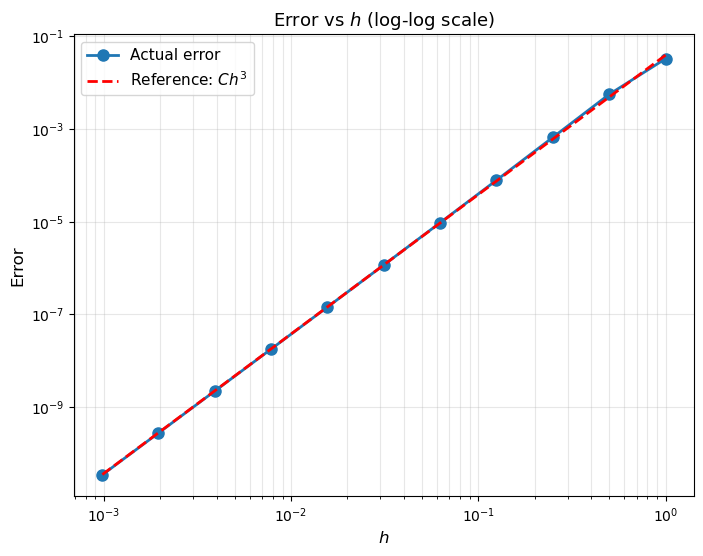

In [17]:
# Estimate q from error ratios: if error = C*h^q, then error_i/error_{i+1} = 2^q
ratios = errors[:-1] / errors[1:]
q_estimates = np.log2(ratios)
q = int(np.round(np.mean(q_estimates[2:])))  # Use middle values
print(f"Error ratios (error_i/error_{{i+1}}): {ratios}")
print(f"Estimated q values: {q_estimates}")
print(f"Average q ≈ {np.mean(q_estimates[2:]):.2f}, so q = {q}")

# Log-log plot
plt.figure(figsize=(8, 6))
plt.loglog(h_values, errors, 'o-', label='Actual error', markersize=8, linewidth=2)

# Reference line: C*h^q (fit C using a middle data point for better stability)
C = errors[5] / (h_values[5]**q)
reference = C * np.array(h_values)**q
plt.loglog(h_values, reference, '--', label=f'Reference: $Ch^{{{q}}}$', linewidth=2, color='red')

plt.xlabel('$h$', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend(fontsize=11)
plt.title('Error vs $h$ (log-log scale)', fontsize=13)
plt.show()


Yes, the error satisfies a power law $Ch^q$ with $q = 3$. We can estimate $q$ by computing the ratio of consecutive errors: since $h_{i+1} = h_i/2$, we have $\frac{\text{error}_i}{\text{error}_{i+1}} = 2^q \approx 8$, giving $q = \log_2(8) = 3$.

In the log-log plot, the relationship $\text{error} = Ch^q$ becomes linear: $\log(\text{error}) = \log(C) + q\log(h)$. The slope of this line equals $q$. When $h$ decreases by a factor of 2 (moving one unit left on the log scale), the error decreases by a factor of $2^3 = 8$ (moving proportionally down).

For standard Lagrange interpolation with 4 points, the polynomial has degree 3, and the error is proportional to $h^4$ (one power higher than the degree). The non-standard formula is less accurate, with error proportional to $h^3$ instead of $h^4$.
